In [3]:
import pandas as pd
import zipfile
import trueskill
import matplotlib.pyplot as plt

In [28]:
with zipfile.ZipFile('data/contest_results.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

df = pd.read_csv('./extracted_files/contest_results.csv', parse_dates=['contest_date'])
df.loc[df['placing'] > 16, 'placing'] = 16
df = df[['organization', 'contest_name', 'contest_date', 'division', 'class', 'competitor_name', 'placing']]
df.loc[df["division"] == "women\'s wellness", "division"] = "wellness"
df = df.dropna()

# TrueSkill Rating Column
Here we will create a column in df that is the competitor's TrueSkill rating leading up to that competition.

In [29]:
df = df.sort_values(
    by=[
        "contest_date",
        "organization",
        "contest_name",
        "division",
        "class",
        "placing",
        "competitor_name"
    ],
    ascending=True,
)

In [34]:
competitors = {}

for contest_date in df["contest_date"].unique():
    df_dt = df[df['contest_date'] == contest_date]
    for org in df_dt["organization"].unique():
        df_org = df_dt[df_dt['organization'] == org]
        for contest_name in df_org["contest_name"].unique():
            df_ctst = df_org[df_org["contest_name"] == contest_name]
            for div in df_ctst["division"].unique():
                df_div = df_ctst[df_ctst["division"] == div]
                for clss in df_div["class"].unique():
                    df_temp = df_div[df_div["class"] == clss]
                    if len(df_temp) < 2:
                        continue
                    ts_competitors = []
                    rankings = []
                    for index, row in df_temp.iterrows():
                        name = row["competitor_name"]
                        rank = row["placing"]
                        if name not in competitors:
                            competitors[name] = trueskill.Rating()
                        df.loc[index, "trueskill_rating"] = competitors[name].mu
                        ts_competitors.append([competitors[name]])
                        rankings.append(rank)
                    out = trueskill.rate(ts_competitors, ranks=rankings)
                    i = 0
                    for index, row in df_temp.iterrows():
                        name = row["competitor_name"]
                        competitors[name] = out[i][0]
                        i += 1

In [35]:
df["trueskill_rank"] = df.groupby(
    ["organization", "contest_date", "contest_name", "division", "class"]
)["trueskill_rating"].rank(ascending=False, method="first")
df.loc[df["trueskill_rank"] > 16, "trueskill_rank"] = 16

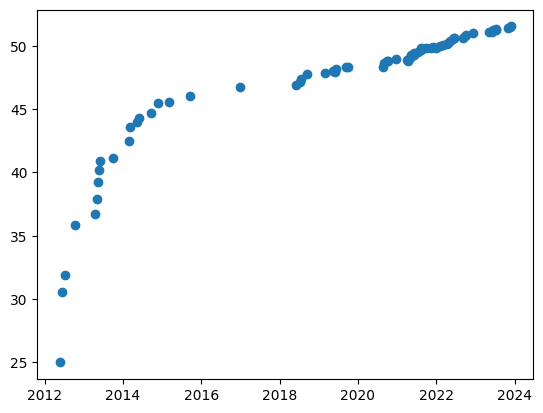

In [36]:
plt.scatter(df[df['competitor_name'] == 'ashley kaltwasser']['contest_date'],
            df[df['competitor_name'] == 'ashley kaltwasser'][f'trueskill_rating'])

In [37]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,trueskill_rating,trueskill_rank
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,25.0,1.0
17037,ifbb,ifbb flex pro,2012-02-18,fitness,open,oksana grishina,2.0,25.0,2.0
17036,ifbb,ifbb flex pro,2012-02-18,fitness,open,myriam capes,3.0,25.0,3.0
17035,ifbb,ifbb flex pro,2012-02-18,fitness,open,tanji johnson,4.0,25.0,4.0
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,25.0,5.0


In [38]:
df.to_csv('contest_results_trueskill.csv')